## Track on Radar data, segment on satellite data

### In addition to the normal *tobac* requirements, this tutorial also requires that Py-ART and s3fs are installed.

In [1]:
%matplotlib inline

In [2]:
import pyart
import xarray as xr
import s3fs
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.pyplot import cm as cmaps
import pandas as pd
from pyproj import Proj, Geod


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
# read in radar data
radar = pyart.io.read_nexrad_archive("s3://noaa-nexrad-level2/2021/05/26/KGLD/KGLD20210526_155623_V06")

In [4]:
# read in satellite data
fs = s3fs.S3FileSystem(anon=True)
aws_url = 's3://noaa-goes16/ABI-L2-MCMIPC/2021/146/15/OR_ABI-L2-MCMIPC-M6_G16_s20211461556154_e20211461558539_c20211461559030.nc'
goes_data = xr.open_dataset(fs.open(aws_url), engine='h5netcdf')

In [5]:
'''
Because the GOES data comes in without latitude/longitude values, we need to calculate those. 
'''

def lat_lon_reproj(g16nc):

    # GOES-R projection info and retrieving relevant constants
    proj_info = g16nc["goes_imager_projection"]
    lon_origin = proj_info.attrs["longitude_of_projection_origin"]
    H = proj_info.attrs["perspective_point_height"] + proj_info.attrs["semi_major_axis"]
    r_eq = proj_info.attrs["semi_major_axis"]
    r_pol = proj_info.attrs["semi_minor_axis"]

    # grid info
    lat_rad_1d = g16nc.variables["x"][:]
    lon_rad_1d = g16nc.variables["y"][:]

    # create meshgrid filled with radian angles
    lat_rad, lon_rad = np.meshgrid(lat_rad_1d, lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin * np.pi) / 180.0

    a_var = np.power(np.sin(lat_rad), 2.0) + (
        np.power(np.cos(lat_rad), 2.0)
        * (
            np.power(np.cos(lon_rad), 2.0)
            + (((r_eq * r_eq) / (r_pol * r_pol)) * np.power(np.sin(lon_rad), 2.0))
        )
    )
    b_var = -2.0 * H * np.cos(lat_rad) * np.cos(lon_rad)
    c_var = (H**2.0) - (r_eq**2.0)

    r_s = (-1.0 * b_var - np.sqrt((b_var**2) - (4.0 * a_var * c_var))) / (2.0 * a_var)

    s_x = r_s * np.cos(lat_rad) * np.cos(lon_rad)
    s_y = -r_s * np.sin(lat_rad)
    s_z = r_s * np.cos(lat_rad) * np.sin(lon_rad)

    lat = (180.0 / np.pi) * (
        np.arctan(
            ((r_eq * r_eq) / (r_pol * r_pol))
            * ((s_z / np.sqrt(((H - s_x) * (H - s_x)) + (s_y * s_y))))
        )
    )
    lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return lon, lat


In [6]:
# First, we need to grid the input radar data. 
radar_grid_pyart = pyart.map.grid_from_radars(radar, grid_shape=(41, 401, 401),
                                  grid_limits=((0.,20000,), (-200000., 200000.), (-200000, 200000.)))


/users/kukulies/anaconda3/envs/python3.10/lib/python3.10/site-packages/pyart/graph/gridmapdisplay.py:239: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Mercator.
  warnings.warn(


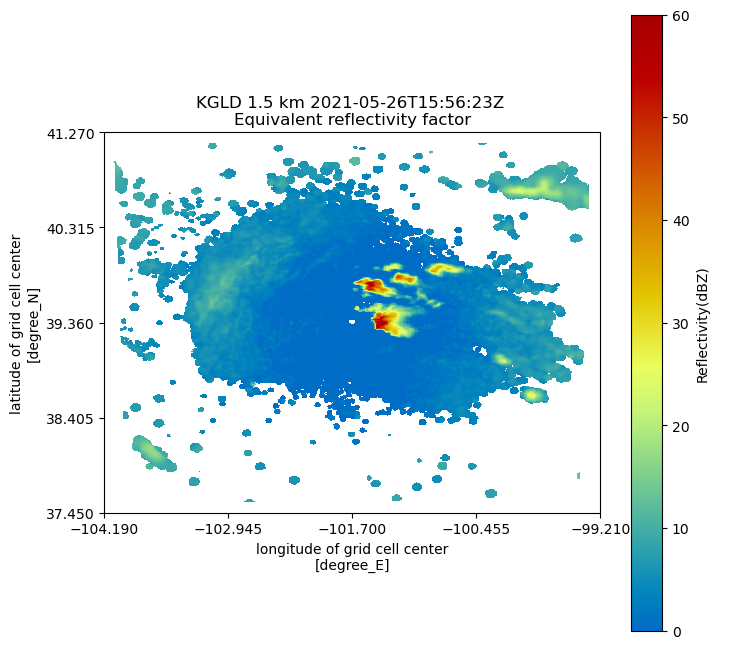

In [7]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[8, 8])
plt.axis('off')

display = pyart.graph.GridMapDisplay(radar_grid_pyart)
display.plot_grid('reflectivity', level=3, vmin=0, vmax=60, fig=fig)


In [8]:
radar_xarray_grid = radar_grid_pyart.to_xarray()

In [9]:
goes_data.goes_imager_projection.longitude_of_projection_origin

-75.0

In [10]:
goes_data['time_bounds'][0].values

numpy.datetime64('2021-05-26T15:56:15.477525888')

In [11]:
llons, llats  = lat_lon_reproj(goes_data)
full_goes_data = goes_data['CMI_C10'].values
in_goes_for_tobac = xr.Dataset(data_vars=
    {
        "C10_brightness_temperature": (("time","Y", "X"), [full_goes_data],)
    },
    coords=
    {
        "time": [goes_data['time_bounds'][0].values],
    "longitude": (["Y", "X"], llons),
    "latitude": (["Y", "X"], llats)},
)


/tmp/ipykernel_49148/584919884.py:35: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0 * b_var - np.sqrt((b_var**2) - (4.0 * a_var * c_var))) / (2.0 * a_var)


In [12]:
import tobac
import tobac.utils

/home/kukulies/projects/tobac/tobac/tobac/utils/internal.py:452: UserWarning: Numba not able to be imported; periodic boundary calculations will be slower.Exception raised: ModuleNotFoundError("No module named 'numba'")
  warnings.warn(
/home/kukulies/projects/tobac/tobac/tobac/utils/internal.py:452: UserWarning: Numba not able to be imported; periodic boundary calculations will be slower.Exception raised: ModuleNotFoundError("No module named 'numba'")
  warnings.warn(


In [13]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4


In [14]:
radar_xr_grid_full = radar_xarray_grid['reflectivity'][:,4]
radar_xr_grid_full['z'] = radar_xr_grid_full.z.assign_attrs({'standard_name': 'altitude'})
radar_xr_grid_full['lat'] = radar_xr_grid_full.lat.assign_attrs({'standard_name': 'latitude'})
radar_xr_grid_full['lon'] = radar_xr_grid_full.lon.assign_attrs({'standard_name': 'longitude'})


In [15]:
radar_grid_iris = radar_xr_grid_full.to_iris()


In [16]:
radar_features = tobac.feature_detection.feature_detection_multithreshold(radar_grid_iris, 0, **feature_detection_params)

In [17]:
radar_features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,altitude,latitude,longitude
0,0,5,258.862284,271.851509,19,30,1,2021-05-26 15:56:23,2021-05-26 15:56:23,58862.283666,71851.508909,71851.508909,39.893281,-100.858070
1,0,9,250.469609,240.740283,6,40,2,2021-05-26 15:56:23,2021-05-26 15:56:23,50469.608638,40740.283179,40740.283179,39.819857,-101.223255
2,0,11,198.778758,225.305252,54,50,3,2021-05-26 15:56:23,2021-05-26 15:56:23,-1221.242078,25305.251764,25305.251764,39.355590,-101.405959
3,0,12,243.316368,217.254572,7,50,4,2021-05-26 15:56:23,2021-05-26 15:56:23,43316.368018,17254.571781,17254.571781,39.756323,-101.498434


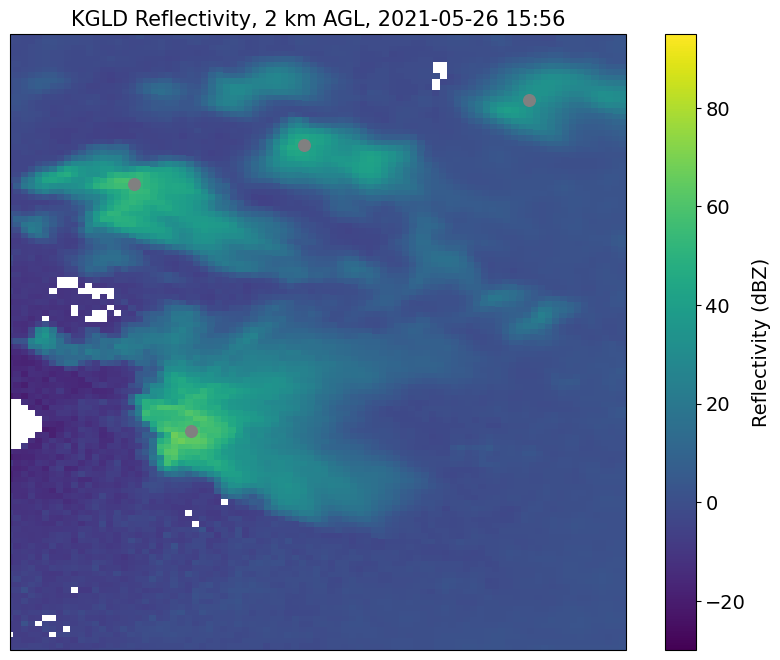

In [18]:
# we now have 4 detected features in 3D space. 

fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())

cm = ax.pcolormesh(radar_xarray_grid['lon'], radar_xarray_grid['lat'], radar_xarray_grid['reflectivity'][0,4], vmin=-30, vmax=95,
                  transform=ccrs.PlateCarree(), cmap = 'viridis')
plt.xlim(-101.7, -100.7)
plt.ylim(39., 40)
cb = plt.colorbar(cm)
cb.set_label("Reflectivity (dBZ)", size=14)
cb.ax.tick_params(labelsize=14)
plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)
plt.scatter(radar_features['longitude'], radar_features['latitude'], 70, transform=ccrs.PlateCarree(), color='grey')


In [19]:
goes_array_iris = in_goes_for_tobac["C10_brightness_temperature"].to_iris()

In [20]:
# maximum space away in m,  maximum time away as Python Datetime object
goes_adj_features = tobac.utils.transform_feature_points(radar_features, goes_array_iris, max_time_away=datetime.timedelta(minutes=1), max_space_away=20*1000)

/home/kukulies/projects/tobac/tobac/tobac/utils/general.py:768: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  old_feat_times = ret_features["time"].astype("datetime64[s]")
/home/kukulies/projects/tobac/tobac/tobac/utils/general.py:769: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Varia

In [21]:
# the transformed dataframe needs to have identical time to the data to segment on. 
#replacement_dt = np.datetime64(in_goes_for_tobac['time'][0].values, 's')
# however, iris cannot deal with times in ms, so we need to drop the ms values.

#goes_adj_features['time'] = replacement_dt

In [21]:
field_time = goes_array_iris.slices_over("time")

In [22]:
goes_adj_features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,altitude,latitude,longitude
index,,,,,,,,,,,,,,
0,0.0,5.0,372.0,806.0,19.0,30.0,1,2021-05-26 15:56:15,2021-05-26 15:56:23,58862.283666,71851.508909,71851.508909,39.893281,-100.858070
1,0.0,9.0,376.0,791.0,6.0,40.0,2,2021-05-26 15:56:15,2021-05-26 15:56:23,50469.608638,40740.283179,40740.283179,39.819857,-101.223255
2,0.0,11.0,393.0,777.0,54.0,50.0,3,2021-05-26 15:56:15,2021-05-26 15:56:23,-1221.242078,25305.251764,25305.251764,39.355590,-101.405959
3,0.0,12.0,379.0,781.0,7.0,50.0,4,2021-05-26 15:56:15,2021-05-26 15:56:23,43316.368018,17254.571781,17254.571781,39.756323,-101.498434


In [23]:
parameters_segmentation=dict()
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=235
parameters_segmentation['target']='minimum'

In [25]:
seg_data, seg_feats = tobac.segmentation.segmentation(goes_adj_features, goes_array_iris, dxy=2000,**parameters_segmentation)

In [26]:
seg_data_xr = xr.DataArray.from_iris(seg_data)

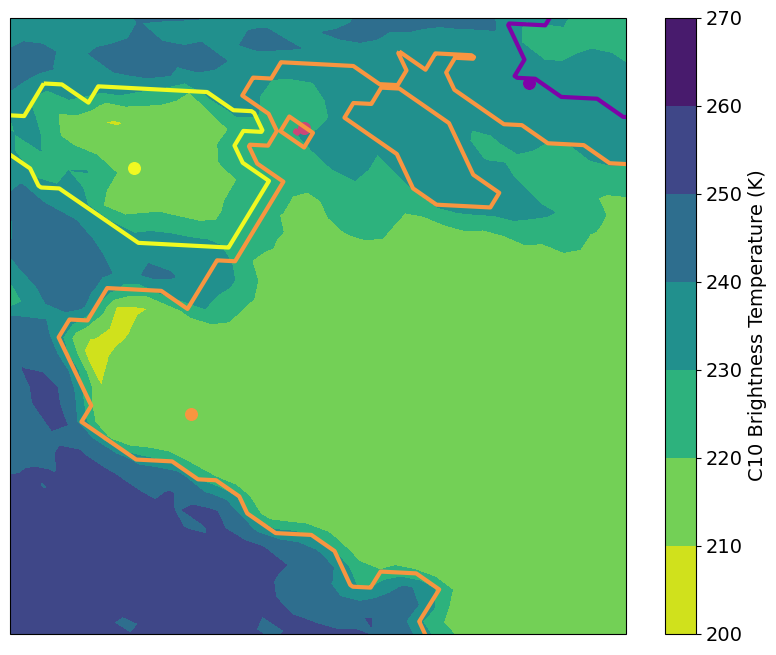

In [27]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())

contoured = ax.contourf(in_goes_for_tobac['longitude'], in_goes_for_tobac['latitude'], in_goes_for_tobac['C10_brightness_temperature'][0],
                  transform=ccrs.PlateCarree(), cmap = 'viridis_r')
plt.xlim(-101.7, -100.7)
plt.ylim(39., 40)
unique_seg = np.unique(seg_data_xr)
color_map = cmaps.plasma(np.linspace(0, 1, len(unique_seg)))

# we have one feature without a segmented area
curr_feat = goes_adj_features[goes_adj_features['feature']==1]
plt.scatter(curr_feat['longitude'], curr_feat['latitude'], 70, transform=ccrs.PlateCarree(), color='grey')


for seg_num, color in zip(unique_seg, color_map):
    if seg_num == 0 or seg_num == -1:
        continue
    curr_seg = (seg_data_xr == seg_num).astype(int)
    ax.contour(seg_data_xr['longitude'], seg_data_xr['latitude'], curr_seg, colors=[color,], levels=[0.9,], linewidths=3)
    curr_feat = goes_adj_features[goes_adj_features['feature']==seg_num]
    plt.scatter(curr_feat['longitude'], curr_feat['latitude'], 70, transform=ccrs.PlateCarree(), color=color)

cb = plt.colorbar(contoured)
cb.set_label("C10 Brightness Temperature (K)", size=14)
cb.ax.tick_params(labelsize=14)
#plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)
#plt.savefig("./radar_example_2/satellite_wseg.png", facecolor='w', bbox_inches='tight')